### Loading relevant packages and libraries (and autoreload):

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow_examples.models.pix2pix import pix2pix

In [92]:
from xrayproject import segmentation_DAM
from xrayproject.utils_DAM import load_train, load_masks
from xrayproject.preprocessing import normalize, flip_resize, resize_test

## We want to create a bunch of functions that integrate Kim's baseline classification-model with David's segmentation-model. How do we want to do this?

### First, to do anything, we need to import raw images. Our full model will be designed to run on only these raw images...

In [13]:
path_image = '../raw_data/raw_PRC/CXR_png/'
path_mask = '../raw_data/raw_PRC/CXR_mask/'

masks, targets, ID = load_masks(100, get_all = False, get_random = True, balanced = True, path = path_mask)

Using path:  ../raw_data/raw_PRC/CXR_mask/
Using bucket 
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0608_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0333_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0469_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0433_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0386_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0662_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0388_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0610_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0451_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0625_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0591_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0423_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0479_1_mas

In [14]:
images, IDs = load_train(ID, path = path_image)

Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0022_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0433_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0610_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0594_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0124_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0225_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0508_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0058_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0380_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0104_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0384_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0630_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0469_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0469_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0139_0

### However, we need to have well-trained segmentation-model. So, to begin with, we're going to load a huge number of image-mask pairs, and train the segmentation model to ensure that we have anything useful.

In [15]:
resized = [flip_resize(images[i], masks[i], input_shape=(224, 224)) for i in range(len(images))]

In [94]:
seg_model = segmentation_DAM.Segmentation_UNET()

In [95]:
seg_model.base_model()

In [96]:
seg_model.unet_model()

In [97]:
seg_model.initialize_model()

Initializing model...


In [98]:
seg_model.train(images, masks, epochs=50)

Preprocessing...
Initializing model...
Starting train..
Epoch 1/50
5/5 [==============================] - 25s 4s/step - loss: 0.6179 - accuracy: 0.7324 - val_loss: 0.5190 - val_accuracy: 0.7556
Epoch 2/50
5/5 [==============================] - 16s 3s/step - loss: 0.4064 - accuracy: 0.7971 - val_loss: 0.3799 - val_accuracy: 0.7968
Epoch 3/50
5/5 [==============================] - 15s 3s/step - loss: 0.3243 - accuracy: 0.8082 - val_loss: 0.2736 - val_accuracy: 0.8829
Epoch 4/50
5/5 [==============================] - 14s 3s/step - loss: 0.2766 - accuracy: 0.8343 - val_loss: 0.1945 - val_accuracy: 0.9462
Epoch 5/50
5/5 [==============================] - 13s 3s/step - loss: 0.2300 - accuracy: 0.8824 - val_loss: 0.1517 - val_accuracy: 0.9514
Epoch 6/50
5/5 [==============================] - 13s 3s/step - loss: 0.2051 - accuracy: 0.9133 - val_loss: 0.1306 - val_accuracy: 0.9575
Epoch 7/50
5/5 [==============================] - 13s 3s/step - loss: 0.1774 - accuracy: 0.9418 - val_loss: 0.1157 -

### Now that the segmentation-model is trained, we then need to design functions that map the outputs of the segmentation-model into a format that the classification-model can properly analyze. We do this here.

#### To start, we define a function that maps the output-predictions of the UNET-model back into images:

In [85]:
def unet_to_mask_img(raw_lung_xray):
    img_funct = seg_model.model.predict(raw_lung_xray[tf.newaxis, ...]).squeeze()
    img_funct = np.sign(img_funct)
    img_funct = (1+np.resize(img_funct, (224, 224, 1)))/2
    return img_funct

In [84]:
print(resized[0][0].shape,
      resized[0][1].shape,
      resized[0][2].shape,
      resized[0][3].shape)

(224, 224, 3) (224, 224, 1) (224, 224, 3) (224, 224, 1)


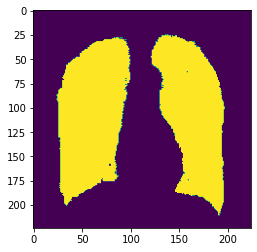

In [86]:
plt.imshow(unet_to_mask_img(resized[5][0]))
plt.show()

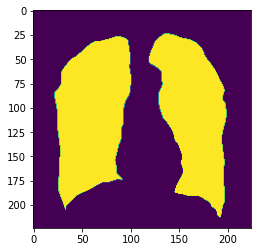

In [87]:
plt.imshow(resized[5][1])
plt.show()

#### It's helpful to have totally new images and masks, to gain confidence that the model actually predicts masks reasonably well:

In [99]:
new_masks, new_targets, new_ID = load_masks(100, get_all = False, get_random = True, balanced = True, path = path_mask)

Using path:  ../raw_data/raw_PRC/CXR_mask/
Using bucket 


In [100]:
new_images, new_IDs = load_train(new_ID, path = path_image)

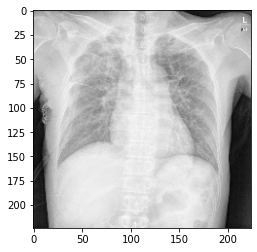

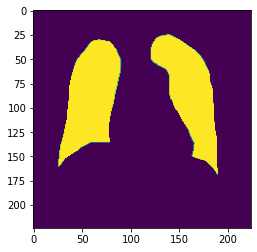

In [101]:
new_xray_imgs = [tf.image.resize(new_images[i]/255, (224, 224)) for i in range(len(new_images))]
new_xray_masks = [tf.image.resize(new_masks[i]/255, (224, 224)) for i in range(len(new_images))]

plt.imshow(new_xray_imgs[0])
plt.show()

plt.imshow(new_xray_masks[0])
plt.show()

#### Now, with these new images/masks, we print-out the outputs and compare them:

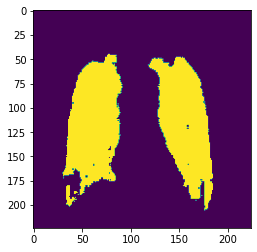

In [54]:
plt.imshow(unet_to_mask_img(new_xray_imgs[5]))
plt.show()

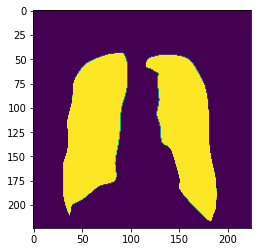

In [52]:
plt.imshow(new_xray_masks[5])
plt.show()

### Now that we see that the model works OK on these new lungs, we need to output a set of model-generated masks for the downstream pathology-prediction model. We do this here:

In [126]:
# from tensorflow.keras.models import load_model
# seg_model.model.save('XXXXXXX')  # creates a HDF5 file 'my_model.h5'

In [115]:
seg_model_224 = tf.keras.models.load_model('seg_model_224')

In [116]:
loaded_model = tf.keras.models.load_model('model')

In [123]:
def unet_to_mask_img(raw_lung_xray,mask_model=seg_model):
    if mask_model == seg_model:        
        img_funct = mask_model.model.predict(raw_lung_xray[tf.newaxis, ...]).squeeze()
#         img_funct = np.sign(img_funct)
        img_funct = (1+np.resize(np.sign(img_funct), (224, 224, 1)))/2
    elif mask_model == seg_model_224:
        img_funct = mask_model.predict(raw_lung_xray[tf.newaxis, ...]).squeeze()
#         img_funct = np.sign(img_funct)
        img_funct = (1+np.resize(np.sign(img_funct), (224, 224, 1)))/2        
    else:
        img_funct = tf.image.resize(raw_lung_xray, (128, 128))
        img_funct = mask_model.predict(img_funct[tf.newaxis, ...]).squeeze()
#         img_funct = np.sign(img_funct)
        img_funct = (1+np.resize(np.sign(img_funct), (128, 128, 1)))/2
    return img_funct

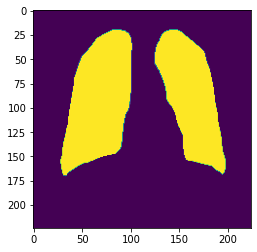

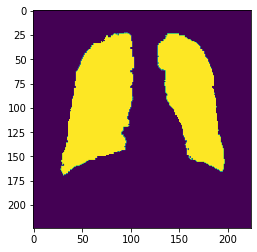

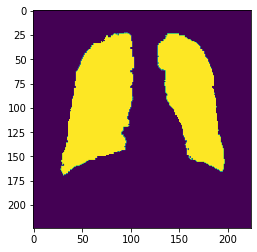

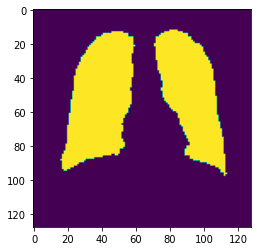

In [125]:
num = 5

plt.imshow(new_xray_masks[num])
plt.show()

plt.imshow(unet_to_mask_img(new_xray_imgs[num]))
plt.show()

plt.imshow(unet_to_mask_img(new_xray_imgs[num], mask_model=seg_model_224))
plt.show()

plt.imshow(unet_to_mask_img(new_xray_imgs[num], mask_model=loaded_model))
plt.show()

# plt.imshow(unet_to_mask_img(new_xray_imgs[5],mask_model=seg_model))
# plt.show()



### Finally, we feed these modified outputs of the segmentation-model into the classifier model, and see how well it does.